In [1]:
import os
import numexpr as ne
ne.set_num_threads(32)
ne.set_num_threads(32)
import sys
import cactusLib.cactusUtils as cu
from cactusLib.cactusLib import mapAnalysisObject2 as mao
from cactusLib.cactusCatalogs import readCatalog
import numpy as np
import os
from datetime import datetime
import scipy
from flipper import fftTools
from cactusLib import filterLib
import matplotlib.pyplot as plt
from cactusLib.cactusBeams import getBeamSpline, getBeamNorm
from scipy import ndimage
from cactusLib.filterLib import symmetrizeFFT
from flipper import liteMap

/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .circular_overlap import *       # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .elliptical_overlap import *     # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .rectangular_overlap import *    # noqa


In [2]:
i = 0

In [3]:
paramfile = "./ar2s2.par"
#simrange = [0,1]
outdir = "test_sim_maps_nr"
catname = "./test_sim_cats/"
tag = "ACT_220_s2_sim_full"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
startTime = datetime.now()
ma = mao(paramfile)
mapData = ma.Map.map.data.copy()
#print "Processing sim %d/%d" % (i+1, simrange[1] - simrange[0])

#print "Proccessing sim{}".format(i)

ma.Map.map.data = mapData.copy()


In [4]:
lt = ma.Map.map.copy()
lt.data[:] = lt.data*np.sqrt(ma.Map.weights.data)/np.sqrt(np.max(ma.Map.weights.data))

noiseMap = lt.copy()

pad = 80
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = noiseMap.data.copy()
apod[:] = 0.0
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,40,mode="constant")

Wms = np.sum(N_apod**2)/N_apod.size
f = np.sqrt(1./Wms)


In [5]:
#ltaper = liteMap.liteMapFromFits("./auxf/220_s2_taper_full.fits")
#N_apod = ltaper.data
#Wms = np.sum(N_apod**2)/N_apod.size
#f = 1./Wms

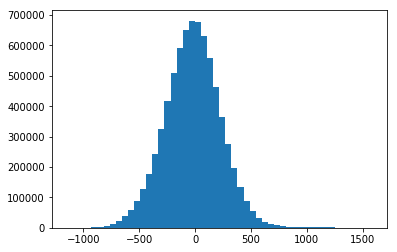

In [6]:
plt.hist(lt.data.flatten(),50)
plt.show()

In [7]:
np.mean(lt.data)

-20.614262166148173

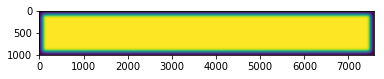

In [8]:
plt.imshow(N_apod)
plt.show()

In [9]:
#from scipy.signal import hamming
#import numpy as np
#import matplotlib.pyplot as plt

In [10]:
#nx = lt.Nx
#ny = lt.Ny
#hy = hamming(ny)
#hx = hamming(nx)
#N_apod = np.sqrt(np.outer(hy,hx)) 

In [11]:
#Wms = np.sum(N_apod**2)/N_apod.size
#f = 1./Wms


In [12]:
#plt.imshow(N_apod)

In [13]:
FTmap = fftTools.fftFromLiteMap(lt)
CMB_apod = lt.data*N_apod

In [14]:
pixsize = np.sqrt(FTmap.pixScaleY*FTmap.pixScaleX)
#pixsize = np.mean([FTmap.pixScaleY,FTmap.pixScaleX])

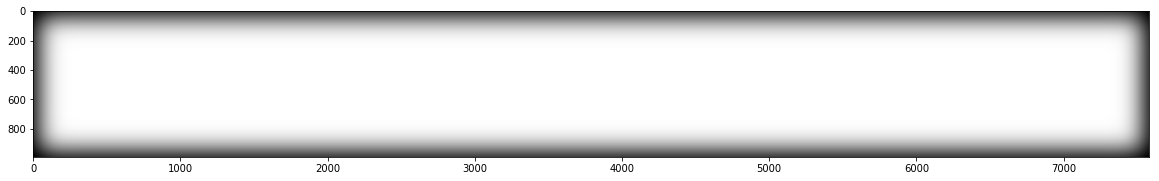

In [15]:
mu = 0.
sigma = 1.
Ny,Nx = lt.data.shape
new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
new_exp = new/np.abs(new)


#We need the apodize the map before taking the FFT ###############
#or the spectrum will be too noise

noiseMap = lt.copy()

pad = 40
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = noiseMap.data.copy()
apod[:] = 0.0
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,80,mode="constant")

plt.figure(figsize=(20,15))
plt.imshow(N_apod,cmap="gray")
plt.show()

noiseMap.data *= N_apod

FTNM = fftTools.fftFromLiteMap(noiseMap)

a = np.abs(FTNM.kMap)

##################################################################

#Factor by the apodization
Ny,Nx = FTNM.kMap.shape
A = np.sqrt(Nx*Ny)/(np.sqrt(np.sum(np.abs(N_apod)**2)))

M_fft2 = a*new_exp

M_fft2 *= A

M_fft2 = filterLib.symmetrizeFFT(M_fft2)
M = np.real(np.fft.ifft2(M_fft2))
Map = M

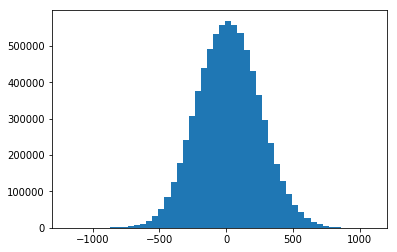

In [16]:
plt.hist(Map.flatten(),50)
plt.show()

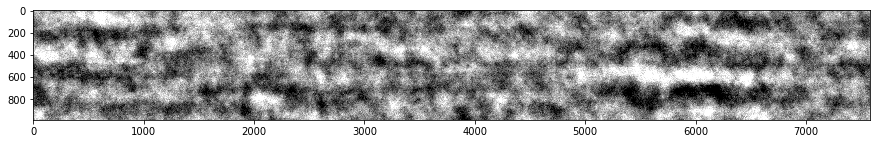

In [17]:
plt.figure(figsize=(15,10))
plt.imshow(Map,vmin=-500,vmax=500,cmap="gray")
plt.show()

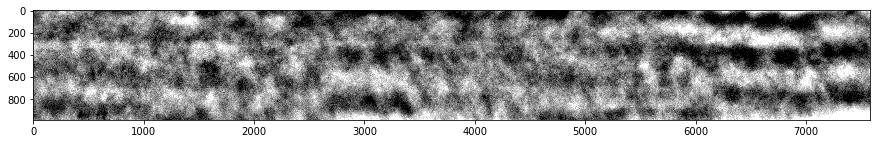

In [18]:
plt.figure(figsize=(15,10))
plt.imshow(lt.data,vmin=-500,vmax=500,cmap="gray")
plt.show()

In [19]:
#Checking the filters normalization

#ma1 map that we just made
ma1 = mao(paramfile)
#ma1.Map.map.data = Map
ma1.noise.data[:] = Map*N_apod


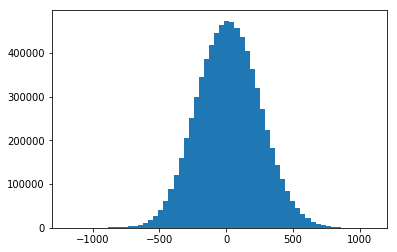

In [20]:
plt.hist(Map.flatten(),60)
plt.show()

In [21]:
ma2 = mao(paramfile)
#ma2.Map.map.data = Map


In [22]:
ma2.params["mapFile"]

'/home/cvargas/sim_test/auxf/220_s2_noise_inv_full.fits'

In [23]:
OMap = ma2.Map.map.data*np.sqrt(ma2.Map.weights.data)/np.sqrt(np.max(ma2.Map.weights.data))
ma2.noise.data[:] = OMap*N_apod

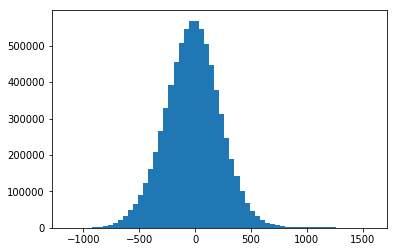

In [24]:

plt.hist(OMap.flatten(),60)
plt.show()

In [25]:
FT1 = fftTools.fftFromLiteMap(ma1.noise)
FT2 = fftTools.fftFromLiteMap(ma2.noise)

In [26]:
FT1.kMap *= A
FT2.kMap *= A

In [27]:
T_other21 = np.real(FT1.kMap*np.conjugate(FT1.kMap))
T_other22 = np.real(FT2.kMap*np.conjugate(FT2.kMap))

In [28]:
beam_ell_file = ma1.params["beamEllFile"]
ellxMin = 100.
ellyMin = 0.
ellMin = 1000.

In [29]:
gFilterSigma = 10.
sigma = np.array([1./FT1.ly[1], 1./FT1.lx[1]], dtype=float) * gFilterSigma
smooth1 = ndimage.gaussian_filter(np.fft.fftshift(T_other21), sigma=sigma)
T_other21 = np.fft.ifftshift(smooth1)

smooth2 = ndimage.gaussian_filter(np.fft.fftshift(T_other22), sigma=sigma)
T_other22 = np.fft.ifftshift(smooth2)

# Beam normalization
# Since the beam is normalized in ell space the value at the central pixel
# will be np.sum(Beam_kk)/Beam_kk.size. We want that value to be 1.
# (normalized in real space) so we divide by it and

Beamspl = getBeamSpline(beam_ell_file)
Beam_kk = Beamspl(FT1.modLMap)
Beam_kk /= getBeamNorm(Beam_kk)

# ell-space mask
lmask = np.ones(FT1.modLMap.shape)
lmask[:, np.abs(FT1.lx) < ellxMin] = 0.  # vertical strip
lmask[np.abs(FT1.ly) < ellyMin] = 0.  # horizontal strip
lmask[FT1.modLMap < ellMin] = 0.  # low-ell circle

# Filter normalization
Norm1 = np.sum((Beam_kk ** 2) * lmask / T_other21) / Beam_kk.size
Norm2 = np.sum((Beam_kk ** 2) * lmask / T_other22) / Beam_kk.size

kFilter1 = Beam_kk * lmask / T_other21 / Norm1

kFilter1sym = symmetrizeFFT(kFilter1)

kFilter2 = Beam_kk * lmask / T_other22 / Norm2

kFilter2sym = symmetrizeFFT(kFilter2)

/home/cvargas/cactusLib/cactusLib/filterLib.py:687: ComplexWarning: Casting complex values to real discards the imaginary part
  out[0, 1:] = (frx0 + np.flipud(frx0)) / 2. + 1j * (fix0 - np.flipud(fix0)) / 2.
/home/cvargas/cactusLib/cactusLib/filterLib.py:688: ComplexWarning: Casting complex values to real discards the imaginary part
  out[1:, 0] = (fry0 + np.flipud(fry0)) / 2. + 1j * (fiy0 - np.flipud(fiy0)) / 2.
/home/cvargas/cactusLib/cactusLib/filterLib.py:689: ComplexWarning: Casting complex values to real discards the imaginary part
  out[1:, 1:] = (fr11 + np.flipud(np.fliplr(fr11))) / 2. + 1j * (fi11 - np.flipud(np.fliplr(fi11))) / 2.


In [30]:
Norm1

4.73376014803626e-11

In [31]:
Norm2

4.7318342125927285e-11

In [32]:
Norm2/Norm1

0.9995931489168647